# Exercise 06 : Scatter Matrix

In [235]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

## Do what you need to do to create a graph like in the example

- create a dataframe where each user of the test group has the average difference, number of pageviews and number of commits
- do not take project1 into account for calculations of the average difference and the number of commits
- take the number of commits from the checker table

In [236]:
connection = sqlite3.connect("../../data/checking-logs.sqlite")

In [237]:
select_query="""
WITH

valid_commits AS (
SELECT 
    commits.uid AS uid,
    commits.num_commits AS num_commits,
    commits.pageviews AS pageviews,
    CAST(julianday(c.timestamp) - julianday(d.deadlines, 'unixepoch') 
        AS INTEGER) * 24 AS diff
FROM
    (
    SELECT 
        c.uid, 
        COUNT(DISTINCT c.timestamp) AS num_commits,
        COUNT(DISTINCT p.datetime) AS pageviews
    FROM checker AS c
    INNER JOIN pageviews AS p ON c.uid = p.uid
    WHERE (
        c.uid LIKE 'user_%'
        AND c.labname <> 'project1'
    )        
    GROUP BY c.uid
    ) AS commits
INNER JOIN checker c ON commits.uid = c.uid
INNER JOIN deadlines AS d ON c.labname = d.labs
            WHERE (
                c.status = 'ready'
                AND c.numTrials = 1
                AND c.uid LIKE 'user_%'
                AND c.labname <> 'project1'
            )
            GROUP BY c.uid, c.labname
            )

SELECT
    uid,
    num_commits,
    pageviews,
    AVG(diff) as avg_diff
FROM valid_commits
GROUP BY uid
"""
df= pd.io.sql.read_sql(select_query, connection)
df

,uid,num_commits,pageviews,avg_diff
0,user_1,62,28,-57.6
1,user_10,20,89,-62.4
2,user_14,61,143,-152.0
3,user_17,51,47,-52.8
4,user_18,5,3,0.0
5,user_19,118,16,-90.0
6,user_21,65,10,-90.0
7,user_25,79,179,-86.4
8,user_28,60,149,-81.6
9,user_3,18,317,-96.0


## Условия для тестовой выборки взяты с предыдущего дня:
- status = ’ready’ should still be a filter
- numTrials = 1 should still be a filter
- the table should contain only the users (uids with user_*) and not the admins
- test should have the users that have the values in first_view_ts

- the figsize is still the same, you can choose whatever fontsize you like as well as the color palette
- the size of the dots should be 200
- the width of the lines of the diagonal graphs (kde) should be 3

array([[<Axes: xlabel='num_commits', ylabel='num_commits'>,
        <Axes: xlabel='pageviews', ylabel='num_commits'>,
        <Axes: xlabel='avg_diff', ylabel='num_commits'>],
       [<Axes: xlabel='num_commits', ylabel='pageviews'>,
        <Axes: xlabel='pageviews', ylabel='pageviews'>,
        <Axes: xlabel='avg_diff', ylabel='pageviews'>],
       [<Axes: xlabel='num_commits', ylabel='avg_diff'>,
        <Axes: xlabel='pageviews', ylabel='avg_diff'>,
        <Axes: xlabel='avg_diff', ylabel='avg_diff'>]], dtype=object)

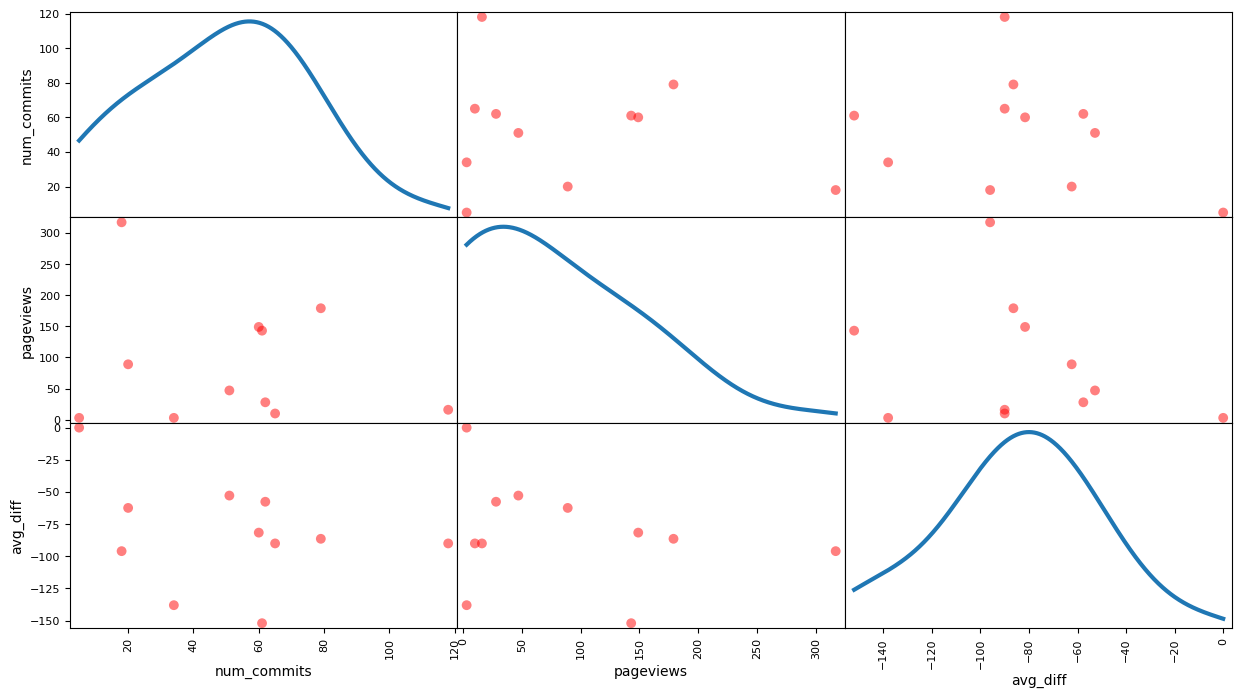

In [238]:
scatter_matrix(df, 
               figsize=(15, 8), 
               diagonal='kde', 
               color='red',
               s = 200,
               density_kwds={'linewidth':3}) 

## Can we say that if a user has a low number of pageviews then they likely have a low number of commits? The answer: yes or no.
* No

## Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?
* No

## Can we say that there are many users with a low number of commits and a few with a high number of commits?
* yes (мб правильнее сказать, что много юзеров со средним количеством коммитов)

## Can we say that there are many users with a small average difference and a few with a large average difference?
* no (похоже скорее на нормальное распределение)

In [239]:
connection.close()